# Probabilistic Methods (Discrete)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

**Anomaly Detection:** Identification of items, events or observations which is significantly different from the remaining data.

- Non-parametric approach
- Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - Less frequent - more likely to be an anomaly
    - Calculate probability 

    
- Conditional probability 
    $$ {P(A|B) = }\frac{\text{P(A and B)}}{\text{P(B)}} $$
    
    
 Examples: 
- How many times we see an ip address in the dataset (count)
- What is probability of ip address showing up in the dataset (ip count / total observations)
- Conditional probability. Given an ip address, what is prob of a particular status(e.g authentication failure)

### Wrangle

The data comes from the webserver logs of the API. Each row is one request to the server

In [2]:
#read in data from sql
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [3]:
#look at data
df

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...
...,...
13969,97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ...
13970,97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ...
13971,97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ...
13972,97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ...


In [4]:
#look at entry data more in-depth
df.entry[0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [5]:
#split entry data on spaces
df.entry[0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [6]:
#split whole dataframe
df = df.entry.str.split(expand=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/sales?page=81,"HTTP/1.1""",200,512495,...,None,None,None,None,None,None,None,None,None,None
1,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/items,"HTTP/1.1""",200,3561,...,None,None,None,None,None,None,None,None,None,None
2,97.105.19.58,-,-,[16/Apr/2019:19:34:44,+0000],"""GET",/api/v1/sales?page=82,"HTTP/1.1""",200,510103,...,None,None,None,None,None,None,None,None,None,None
3,97.105.19.58,-,-,[16/Apr/2019:19:34:46,+0000],"""GET",/api/v1/sales?page=83,"HTTP/1.1""",200,510003,...,None,None,None,None,None,None,None,None,None,None
4,97.105.19.58,-,-,[16/Apr/2019:19:34:48,+0000],"""GET",/api/v1/sales?page=84,"HTTP/1.1""",200,511963,...,None,None,None,None,None,None,None,None,None,None


In [7]:
#look at end columns using loc
df.loc[:,11:].head()

,11,12,13,14,15,16,17,18,19,20,21,22,23
0,"""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
1,"""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
2,"""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
3,"""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None
4,"""python-requests/2.21.0""",None,None,None,None,None,None,None,None,None,None,None,None


In [8]:
#combine end columns together & save back into 11
df[11] = df[11].str.strip('"')

In [9]:
#combine using lambda
df[11] = df.loc[:,11:].apply(lambda rows: ' '.join(rows.values.astype(str)), axis=1).str.replace('None', '').str.strip()

In [10]:
df[11].value_counts()

python-requests/2.21.0                                                                                                        12001
python-requests/2.20.1                                                                                                         1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36"       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)"                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)"                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36"        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, l

In [11]:
#remove end columns using loc
df = df.loc[:, :11]
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/sales?page=81,"HTTP/1.1""",200,512495,"""-""",python-requests/2.21.0
1,97.105.19.58,-,-,[16/Apr/2019:19:34:42,+0000],"""GET",/api/v1/items,"HTTP/1.1""",200,3561,"""-""",python-requests/2.21.0
2,97.105.19.58,-,-,[16/Apr/2019:19:34:44,+0000],"""GET",/api/v1/sales?page=82,"HTTP/1.1""",200,510103,"""-""",python-requests/2.21.0
3,97.105.19.58,-,-,[16/Apr/2019:19:34:46,+0000],"""GET",/api/v1/sales?page=83,"HTTP/1.1""",200,510003,"""-""",python-requests/2.21.0
4,97.105.19.58,-,-,[16/Apr/2019:19:34:48,+0000],"""GET",/api/v1/sales?page=84,"HTTP/1.1""",200,511963,"""-""",python-requests/2.21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13969,97.105.19.58,-,-,[17/Apr/2019:12:55:12,+0000],"""GET",/api/v1/sales?page=62,"HTTP/1.1""",200,511544,"""-""",python-requests/2.21.0
13970,97.105.19.58,-,-,[17/Apr/2019:12:55:12,+0000],"""GET",/api/v1/sales?page=65,"HTTP/1.1""",200,511201,"""-""",python-requests/2.21.0
13971,97.105.19.58,-,-,[17/Apr/2019:12:55:13,+0000],"""GET",/api/v1/sales?page=73,"HTTP/1.1""",200,511781,"""-""",python-requests/2.21.0
13972,97.105.19.58,-,-,[17/Apr/2019:12:55:13,+0000],"""GET",/api/v1/sales?page=69,"HTTP/1.1""",200,510136,"""-""",python-requests/2.21.0


In [12]:
#drop other unnecesary columns
df = df.drop(columns=[1,2,4,10])
df.head()

,0,3,5,6,7,8,9,11
0,97.105.19.58,[16/Apr/2019:19:34:42,"""GET",/api/v1/sales?page=81,"HTTP/1.1""",200,512495,python-requests/2.21.0
1,97.105.19.58,[16/Apr/2019:19:34:42,"""GET",/api/v1/items,"HTTP/1.1""",200,3561,python-requests/2.21.0
2,97.105.19.58,[16/Apr/2019:19:34:44,"""GET",/api/v1/sales?page=82,"HTTP/1.1""",200,510103,python-requests/2.21.0
3,97.105.19.58,[16/Apr/2019:19:34:46,"""GET",/api/v1/sales?page=83,"HTTP/1.1""",200,510003,python-requests/2.21.0
4,97.105.19.58,[16/Apr/2019:19:34:48,"""GET",/api/v1/sales?page=84,"HTTP/1.1""",200,511963,python-requests/2.21.0


In [13]:
#rename columns
df = df.rename(columns={0:'ip',
                  3:'timestamp',
                  5:'request_method',
                  6:'request_path',
                  7:'http_version',
                  8:'status_code',
                  9:'size',
                  11:'user_agent'})

In [14]:
#strip extra quotes
df.request_method = df.request_method.str.strip('"')
df.http_version = df.http_version.str.strip('"')

In [15]:
#format timestamp
df.timestamp = df.timestamp.str.strip('[').str.replace(':', ' ', 1)

In [16]:
df.timestamp = pd.to_datetime(df.timestamp)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [17]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

new

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0
3,97.105.19.58,19/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0


In [18]:
new.timestamp = pd.datetime(new.timestamp.str.strip('"'))

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_14457/1152985495.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  new.timestamp = pd.datetime(new.timestamp.str.strip('"'))


TypeError: cannot convert the series to <class 'int'>

In [19]:
#add to initial dataframe
df = pd.concat([df, new]).reset_index(drop=True)

In [20]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13973,97.105.19.58,2019-04-17 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0
13974,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
13975,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
13976,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0


In [ ]:
#make additional size_mb column
df['size_mb'] = df.size/

In [ ]:
#convert timestamp & set as index
df.set_index(df.timestamp).sort_index()

## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

In [25]:
#look at ip counts
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().rename(columns={'index':'ip',
                                                                            'ip' : 'count'})

In [34]:
# calculate probabity for each ip 
ip_df['ip_prob'] = df.ip.value_counts(normalize=True).values

In [35]:
ip_df.head()

,ip,count,ip_prob
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


#### How many unique IP addresses are there?

In [37]:
#number of unique ip addresses
ip_df.ip.nunique()

22

<AxesSubplot:ylabel='ip'>

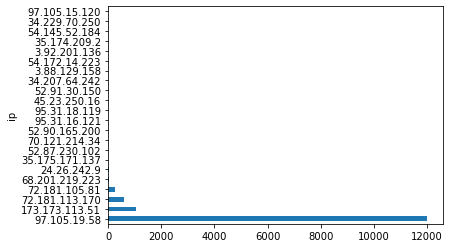

In [42]:
#plot them
ip_df.set_index('ip')['count'].plot.barh()

In [ ]:
#plot them - top 5


### Conditional Probabilities

HTTP Status Codes

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong

- What is probability of a certain status code given an IP address?
$$ {P(A|B) = }\frac{\text{P(A and B)}}{\text{P(B)}} $$

In [ ]:
#prob(A|B) = prob(A & B)/prob(B)

In [44]:
#prob(B)
Pb = df.groupby('ip').size()/len(df)

In [46]:
#prob(A & B)
Pab = df.groupby(['ip', 'status_code']).size()/len(df)

In [47]:
Pab/Pb

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
95.31.16.121    301            1.000000
95.31.18.119    200            1.000000
97.105.15.120   301            1.000000
97.105.19.58    200            0.998833
                499            0.001167
dtype: float

In [50]:
# Given a particular ip, what is probability of a certain status code
#same thing, diferent method, using groupby and normalizing value counts
status_code_ip = df.groupby('ip').status_code.value_counts(normalize=True).rename('proba_status_code_ip').reset_index()

#### Which IP addresses give us multiple status codes?

In [51]:
status_code_ip[status_code_ip.proba_status_code_ip < 1]

,ip,status_code,proba_status_code_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


#### Let's investigate the '72.181.113.170' address

In [52]:
df[df.ip == '72.181.113.170'].sort_values('status_code', ascending=False)

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
12598,72.181.113.170,2019-04-17 02:48:36,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0
13106,72.181.113.170,2019-04-17 03:42:44,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0
13084,72.181.113.170,2019-04-17 03:42:17,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0
13072,72.181.113.170,2019-04-17 03:42:01,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0
13074,72.181.113.170,2019-04-17 03:42:03,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
12815,72.181.113.170,2019-04-17 03:28:07,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0
12816,72.181.113.170,2019-04-17 03:28:08,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0
12817,72.181.113.170,2019-04-17 03:28:11,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0
12818,72.181.113.170,2019-04-17 03:28:13,GET,/api/v1/sales?page=103,HTTP/1.1,200,512764,python-requests/2.21.0


#### What cases don't have a 200 status code?

In [53]:
status_code_ip[status_code_ip.status_code != '200']

,ip,status_code,proba_status_code_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


#### Add these probabilities to original events to detect anomalous events

In [54]:
status_code_ip.head()

,ip,status_code,proba_status_code_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [55]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [57]:
df = df.merge(status_code_ip, how='left', on=['ip', 'status_code'])

#### Which events have the lowest probability of happening?

In [59]:
df[df.proba_status_code_ip < .1]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,proba_status_code_ip
1745,97.105.19.58,2019-04-16 19:55:15,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.001167
1819,97.105.19.58,2019-04-16 19:56:02,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.001167
4242,97.105.19.58,2019-04-16 20:28:46,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
4405,97.105.19.58,2019-04-16 20:33:24,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
4790,97.105.19.58,2019-04-16 20:38:13,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
4862,97.105.19.58,2019-04-16 20:38:55,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
4871,97.105.19.58,2019-04-16 20:39:00,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
5520,97.105.19.58,2019-04-16 20:45:17,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
5539,97.105.19.58,2019-04-16 20:45:28,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.001167
6860,97.105.19.58,2019-04-16 21:00:35,GET,/api/v1/sales?page=115,HTTP/1.1,499,0,python-requests/2.20.1,0.001167


> All low probability combinations are now easily identifiable with all additional data intact